<a href="https://colab.research.google.com/github/prerna-roy/spam_detection_nlp/blob/main/final_script_riya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cleaning and preprocessing data

Read the original dataframe using Pandas.

In [19]:
df_all = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL Project - 6 9 22/data/processed_data.csv")
df_all.head()

label                                            subject  \
0      1                  Generic Cialis, branded quality@    
1      0                             Typo in /debian/README   
2      1                                   authentic viagra   
3      1                               Nice talking with ya   
4      1  or trembling; stomach cramps; trouble in sleep...   

                          email_to  \
0        the00@speedy.uwaterloo.ca   
1  debian-mirrors@lists.debian.org   
2         <the00@plg.uwaterloo.ca>   
3         opt4@speedy.uwaterloo.ca   
4     ktwarwic@speedy.uwaterloo.ca   

                                          email_from  \
0                 "Tomas Jacobs" <RickyAmes@aol.com>   
1         Yan Morin <yan.morin@savoirfairelinux.com>   
2  "Sheila Crenshaw" <7stocknews@tractionmarketin...   
3       "Stormy Dempsey" <vqucsmdfgvsg@ruraltek.com>   
4         "Christi T. Jernigan" <dcube@totalink.net>   

                                             message  
0  Content-Type: text/html;\nContent-Transfer-Enc...  
1  Hi, i've just updated from the gulus and I che...  
2  Content-Type: text/plain;\n\tcharset="iso-8859...  
3  Hey Billy, \n\nit was really fun going out the...  
4  Content-Type: multipart/alternative;\n        ...

In [20]:
# We will focus on using the content of the message from the emails in the dataframe
# We drop the "email_to" and "email_from" columns
df_all.drop(columns = ['email_to', 'email_from'], inplace=True)

We check for null values, and drop them. We also check for duplicates and drop them.

In [21]:
df_all.isnull().sum()

label         0
subject     793
message    1487
dtype: int64

In [22]:
df_all.dropna(inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73211 entries, 0 to 75418
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    73211 non-null  int64 
 1   subject  73211 non-null  object
 2   message  73211 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


There are still over 70k records even after dropping null values. Check for duplicates.

In [23]:
df_all.duplicated().sum()

10847

There are many duplicate records, which are now dropped to prevent issues in training

In [24]:
df_all.drop_duplicates(inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62364 entries, 0 to 75418
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    62364 non-null  int64 
 1   subject  62364 non-null  object
 2   message  62364 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


Now over 10k records were dropped as they were duplicates. Take a look at the dataframe now.

In [14]:
df_all.head(10)

label                                            subject  \
0      1                  Generic Cialis, branded quality@    
1      0                             Typo in /debian/README   
2      1                                   authentic viagra   
3      1                               Nice talking with ya   
4      1  or trembling; stomach cramps; trouble in sleep...   
5      1                                      Which is duty   
6      1                                       For Theorize   
7      1  Theorize get inside for local esc0rts who do i...   
8      1                              Losing Weight Quickly   
9      0               [R] Confidence-Intervals.... help...   

                                             message  
0  Content-Type: text/html;\nContent-Transfer-Enc...  
1  Hi, i've just updated from the gulus and I che...  
2  Content-Type: text/plain;\n\tcharset="iso-8859...  
3  Hey Billy, \n\nit was really fun going out the...  
4  Content-Type: multipart/alternative;\n        ...  
5  Content-Type: multipart/alternative;\n        ...  
6  Content-Type: text/plain;\n\tcharset="Windows-...  
7  Content-Type: Multipart/Alternative;\n  bounda...  
8  Content-Type: text/plain;\n    charset="iso-88...  
9  Hi...\n\nI have to use R to find out the 90% c...

The contents in the `message` column are quite messy and require cleaning. Several steps will be used to clean this column:
* All text will turn into lower case characters
* Rows containing 'Content-Type' will be removed as they contain huge amounts of encoded characters that cannot be efficiently cleaned.
* Replace newline characters with a space 


In [27]:
df_all['message'] = df_all['message'].apply(lambda x: x.lower())
df_all['subject'] = df_all['subject'].apply(lambda x: x.lower())
df_all.head()

label                                            subject  \
0      1                  generic cialis, branded quality@    
1      0                             typo in /debian/readme   
2      1                                   authentic viagra   
3      1                               nice talking with ya   
4      1  or trembling; stomach cramps; trouble in sleep...   

                                             message  
0  content-type: text/html;\ncontent-transfer-enc...  
1  hi, i've just updated from the gulus and i che...  
2  content-type: text/plain;\n\tcharset="iso-8859...  
3  hey billy, \n\nit was really fun going out the...  
4  content-type: multipart/alternative;\n        ...

In [28]:
# Previous size of dataframe, before removing 'Content-Type' rows
df_all.shape

(62364, 3)

In [29]:
# New size of dataframe, after removing 'Content-Type' rows 
df_all = df_all[~df_all['message'].str.contains("content-type")]
df_all.shape

(33830, 3)

In [33]:
# Replacing all \n characters with a space " "
# df_all['message_clean'] = df_all['message'].apply(lambda x: re.sub('\n', ' ', x))
df_all['subject_clean'] = df_all['subject'].apply(lambda x: re.sub('\n', ' ', x))
df_all.head()

label                                   subject  \
1       0                    typo in /debian/readme   
3       1                      nice talking with ya   
9       0      [r] confidence-intervals.... help...   
16      1                                    hi man   
19      0  re: [r] confidence-intervals.... help...   

                                              message  \
1   hi, i've just updated from the gulus and i che...   
3   hey billy, \n\nit was really fun going out the...   
9   hi...\n\ni have to use r to find out the 90% c...   
16  hey billy, \n\nit was really fun going out the...   
19  hm... sounds like a homework problem to me...\...   

                                        message_clean  \
1   hi, i've just updated from the gulus and i che...   
3   hey billy,   it was really fun going out the o...   
9   hi...  i have to use r to find out the 90% con...   
16  hey billy,   it was really fun going out the o...   
19  hm... sounds like a homework problem to me... ...   

                               subject_clean  
1                     typo in /debian/readme  
3                       nice talking with ya  
9       [r] confidence-intervals.... help...  
16                                    hi man  
19  re: [r] confidence-intervals.... help...

Once we have completed these basic preprocessing steps, we drop the original subejct and message columns and keep their respective clean columns for use in text classification.

In [34]:
df = df_all.drop(columns = ['subject', 'message'])
df.head()

label                                      message_clean  \
1       0  hi, i've just updated from the gulus and i che...   
3       1  hey billy,   it was really fun going out the o...   
9       0  hi...  i have to use r to find out the 90% con...   
16      1  hey billy,   it was really fun going out the o...   
19      0  hm... sounds like a homework problem to me... ...   

                               subject_clean  
1                     typo in /debian/readme  
3                       nice talking with ya  
9       [r] confidence-intervals.... help...  
16                                    hi man  
19  re: [r] confidence-intervals.... help...

For the purposes of training, the two columns of `message_clean` and `subject_clean` can be combined to produce a column `content` that contains both the subject and message. 

In [37]:
df['content'] = df['subject_clean'] + " " + df['message_clean'] 
df.head()

label                                      message_clean  \
1       0  hi, i've just updated from the gulus and i che...   
3       1  hey billy,   it was really fun going out the o...   
9       0  hi...  i have to use r to find out the 90% con...   
16      1  hey billy,   it was really fun going out the o...   
19      0  hm... sounds like a homework problem to me... ...   

                               subject_clean  \
1                     typo in /debian/readme   
3                       nice talking with ya   
9       [r] confidence-intervals.... help...   
16                                    hi man   
19  re: [r] confidence-intervals.... help...   

                                              content  
1   typo in /debian/readme hi, i've just updated f...  
3   nice talking with ya hey billy,   it was reall...  
9   [r] confidence-intervals.... help... hi...  i ...  
16  hi man hey billy,   it was really fun going ou...  
19  re: [r] confidence-intervals.... help... hm......

In [ ]:
# Optional: save the csv file containing the final df 
# df.to_csv("/content/drive/MyDrive/Colab Notebooks/DL Project - 6 9 22/data/cleaned_data.csv")

# Exploring the dataset 

The final dataset can be explored to look at the text inside the messages and subject lines. We use a word cloud to visualise the most common words in the message and subject lines for both spam (1) and ham (0) categories.

In [39]:
from wordcloud import WordCloud

(-0.5, 1599.5, 799.5, -0.5)

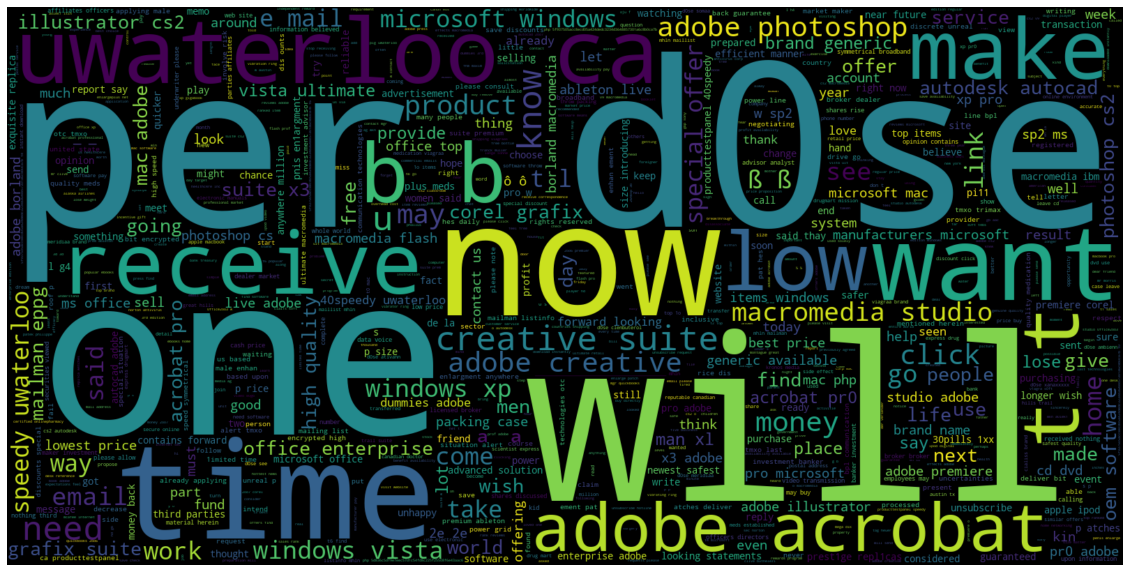

In [40]:
# Word cloud for spam messages
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].message_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

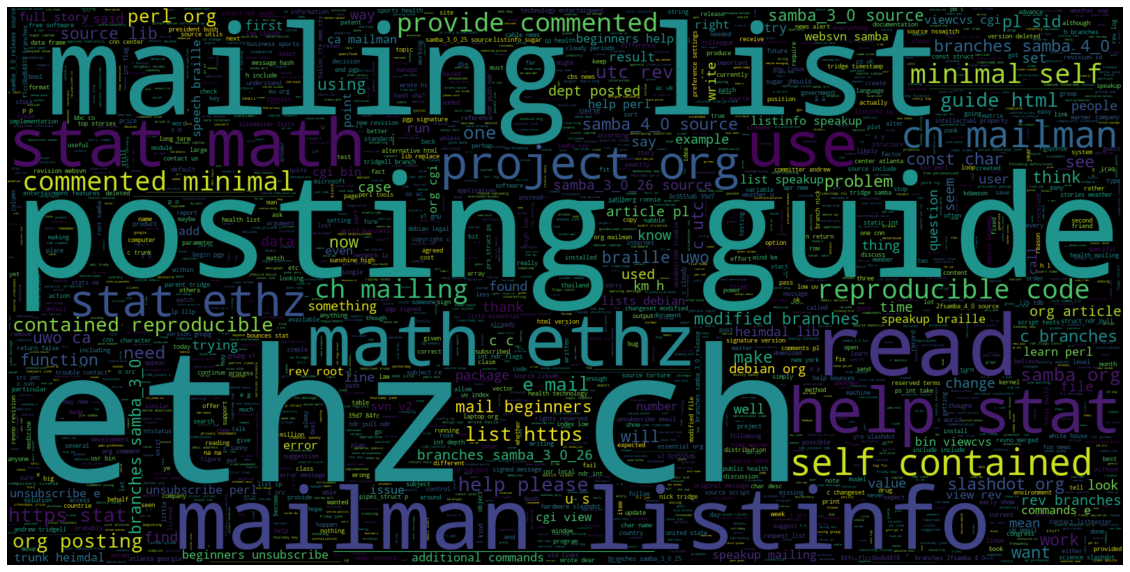

In [41]:
# Word cloud for not spam messages
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].message_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

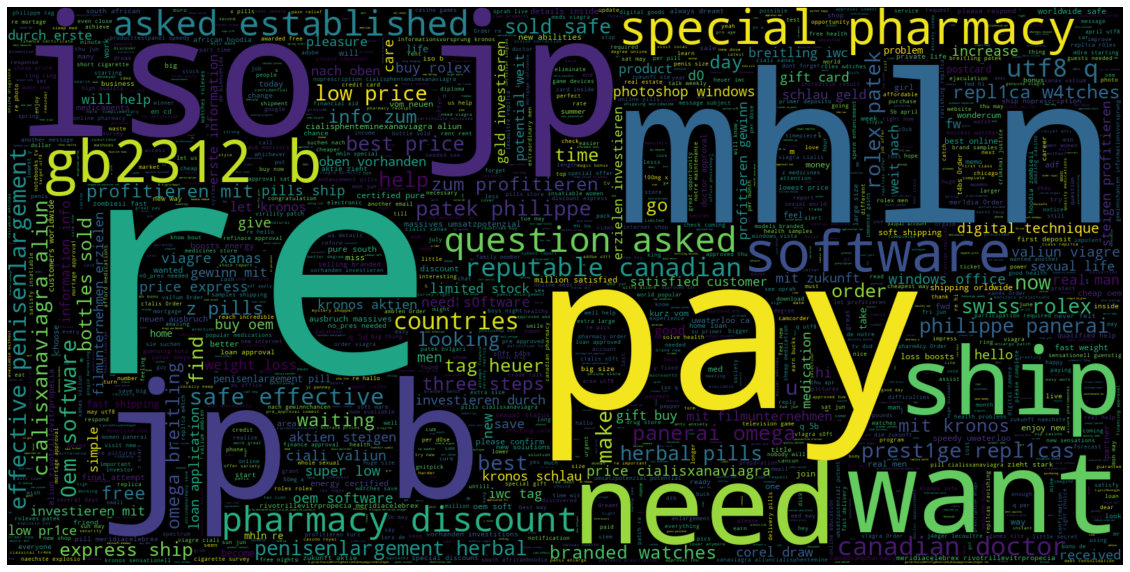

In [42]:
# Word cloud for spam subjects
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].subject_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

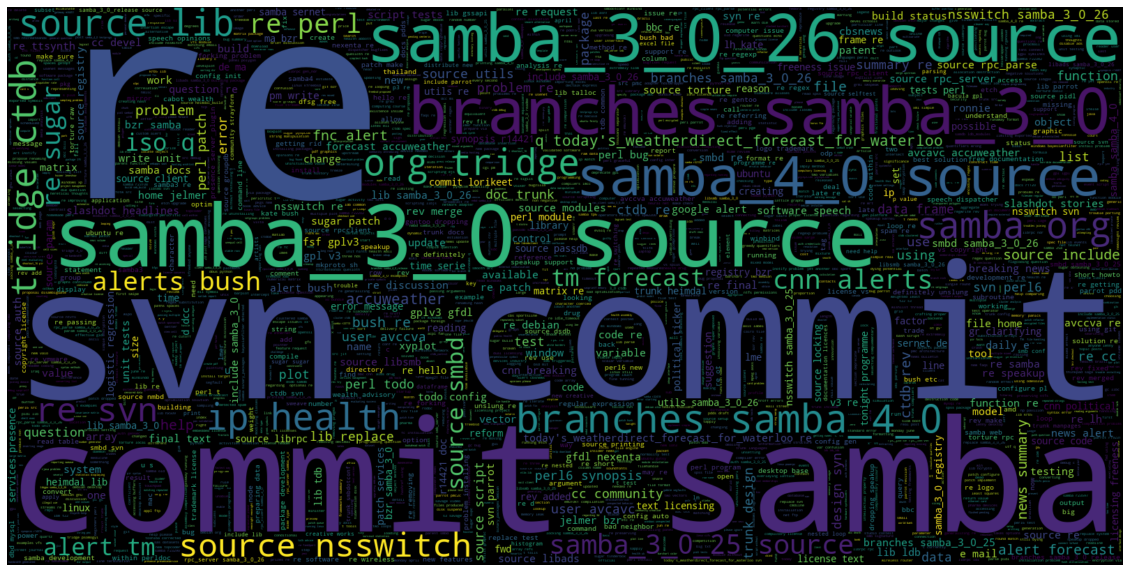

In [43]:
# Word cloud for not spam subjects
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].subject_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

We can see that there while there are some words in the spam messages and subject lines that overlap with the not-spam messages and subject lines, the most common words are quite different between the two classes. An interesting feature noted was that many spam emails use "Re:" in the subject line to try and trick the user that this is an email they have already responded to before. It is so common that "re" itself shows up quite largely in the spam word cloud!

In [44]:
# Creating a dataset used for EDA; avoid overwriting
df_exp = df.copy()

In [45]:
import string 
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [50]:
df_exp['msg_len'] = df_exp.message_clean.apply(lambda x: len(x))
df_exp['sub_len'] = df_exp.subject_clean.apply(lambda x: len(x))
df_exp['msg_punc'] = df_exp.message_clean.apply(lambda x: count(x, string.punctuation))
df_exp['sub_punc'] = df_exp.subject_clean.apply(lambda x: count(x, string.punctuation))
df_exp['msg_letters'] = df_exp.message_clean.apply(lambda x: count(x, string.ascii_letters))
df_exp['msg_numbers'] = df_exp.message_clean.apply(lambda x: count(x, string.digits))
df_exp['sub_letters'] = df_exp.subject_clean.apply(lambda x: count(x, string.ascii_letters))
df_exp['sub_numbers'] = df_exp.subject_clean.apply(lambda x: count(x, string.digits))
df_exp.head()

# df['count_punct'] = df.content.apply(lambda s: count(s, string.punctuation))
# str.count : df['comma_count'] = df.string_column.str.count(',')

label                                      message_clean  \
1       0  hi, i've just updated from the gulus and i che...   
3       1  hey billy,   it was really fun going out the o...   
9       0  hi...  i have to use r to find out the 90% con...   
16      1  hey billy,   it was really fun going out the o...   
19      0  hm... sounds like a homework problem to me... ...   

                               subject_clean  \
1                     typo in /debian/readme   
3                       nice talking with ya   
9       [r] confidence-intervals.... help...   
16                                    hi man   
19  re: [r] confidence-intervals.... help...   

                                              content  msg_len  sub_len  \
1   typo in /debian/readme hi, i've just updated f...      728       22   
3   nice talking with ya hey billy,   it was reall...      649       20   
9   [r] confidence-intervals.... help... hi...  i ...      990       36   
16  hi man hey billy,   it was really fun going ou...      649        6   
19  re: [r] confidence-intervals.... help... hm......     1162       40   

    msg_punc  sub_punc  msg_letters  msg_numbers  sub_letters  sub_numbers  
1         52         2          564           10           18            0  
3         25         0          483            3           17            0  
9        116        10          714           23           24            0  
16        25         0          483            3            5            0  
19       139        11          821           13           26            0

In [57]:
df_exp['label'] = df_exp['label'].astype("category")
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33830 entries, 1 to 75417
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          33830 non-null  object
 1   message_clean  33830 non-null  object
 2   subject_clean  33830 non-null  object
 3   content        33830 non-null  object
 4   msg_len        33830 non-null  int64 
 5   sub_len        33830 non-null  int64 
 6   msg_punc       33830 non-null  int64 
 7   sub_punc       33830 non-null  int64 
 8   msg_letters    33830 non-null  int64 
 9   msg_numbers    33830 non-null  int64 
 10  sub_letters    33830 non-null  int64 
 11  sub_numbers    33830 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.4+ MB


In [76]:
#Descriptive stats of the not-spam records
df_exp[df_exp['label'] == 0].describe()

msg_len       sub_len       msg_punc      sub_punc  \
count   20333.000000  20333.000000   20333.000000  20333.000000   
mean     2188.275414     46.930704     286.814833      4.479565   
std      6019.483730     34.127598     977.035068      5.206510   
min        11.000000      3.000000       0.000000      0.000000   
25%       757.000000     28.000000      74.000000      2.000000   
50%      1221.000000     41.000000     150.000000      3.000000   
75%      2195.000000     60.000000     273.000000      6.000000   
max    671952.000000   1290.000000  100490.000000    135.000000   

         msg_letters   msg_numbers   sub_letters   sub_numbers  
count   20333.000000  20333.000000  20333.000000  20333.000000  
mean     1426.905572     86.345104     34.635224      1.844194  
std      4017.813575    367.943907     24.167954      3.967966  
min         8.000000      0.000000      1.000000      0.000000  
25%       488.000000      9.000000     21.000000      0.000000  
50%       810.000000     27.000000     31.000000      0.000000  
75%      1407.000000     73.000000     43.000000      3.000000  
max    471476.000000  21674.000000   1054.000000     89.000000

In [77]:
#Descriptive stats of the spam records
df_exp[df_exp['label'] == 1].describe()

msg_len       sub_len      msg_punc      sub_punc    msg_letters  \
count   13497.000000  13497.000000  13497.000000  13497.000000   13497.000000   
mean      994.537082     40.031637     56.611321      1.930948     702.416092   
std      2175.096508     33.505493    102.613387      3.160727    1665.085213   
min         1.000000      1.000000      0.000000      0.000000       0.000000   
25%       334.000000     20.000000     15.000000      0.000000     225.000000   
50%       645.000000     32.000000     31.000000      1.000000     444.000000   
75%      1240.000000     51.000000     68.000000      2.000000     910.000000   
max    141935.000000    755.000000   4045.000000     58.000000  111912.000000   

        msg_numbers   sub_letters   sub_numbers  
count  13497.000000  13497.000000  13497.000000  
mean      35.234200     31.076684      1.456250  
std       86.010645     25.729012      4.550875  
min        0.000000      0.000000      0.000000  
25%        3.000000     16.000000      0.000000  
50%       11.000000     25.000000      0.000000  
75%       35.000000     39.000000      1.000000  
max     4499.000000    334.000000    208.000000

We can see that numerically, the features between the two classes are quite different. This can be visualised further using KDE plots.

In [54]:
import seaborn as sns 

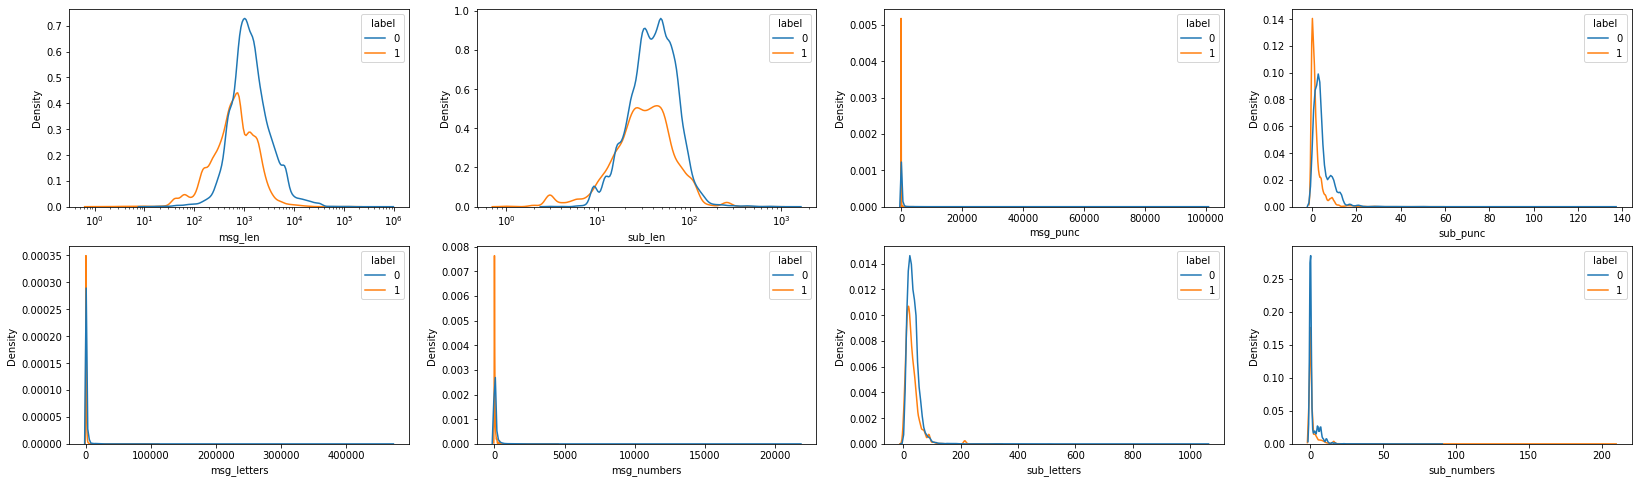

In [97]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (28,8))
sns.kdeplot(data=df_exp, x="msg_len", hue="label", ax=axes[0][0], log_scale=True)
sns.kdeplot(data=df_exp, x="sub_len", hue="label", ax=axes[0][1], log_scale=True)
sns.kdeplot(data=df_exp, x="msg_punc", hue="label", ax=axes[0][2])
sns.kdeplot(data=df_exp, x="sub_punc", hue="label", ax=axes[0][3])
sns.kdeplot(data=df_exp, x="msg_letters", hue="label", ax=axes[1][0], log_scale=True)
sns.kdeplot(data=df_exp, x="msg_numbers", hue="label", ax=axes[1][1])
sns.kdeplot(data=df_exp, x="sub_letters", hue="label", ax=axes[1][2])
sns.kdeplot(data=df_exp, x="sub_numbers", hue="label", ax=axes[1][3])

In [90]:
df_exp[df_exp['msg_letters'] == 0].head()

label                                      message_clean  \
51        1  ×ð¾´µä¹ó¹«ë¾áìµ¼/²æîñ£ºäúºã£¡     îòêçéîã¯£¨éî...   
8481      1  äúºã£¡ ¡¡¡¡ ¡¡¡¡±¾¹«ë¾³éá¢¶àäêóð×åá¼ºãµäéç»á¹ø...   
11104     1  ïèéúäúºã£ºîòë¾óå»ý´ú¿ª½¨öþ°²×°¡¢æû³µðþàí¡¢ôëêä...   
16828     1  ·ð  é½  êð  ìú  ïè  êµ  òµ  óð  ïþ  ¹«  ë¾    ...   
16898     1  ×ð¾´µä¸ºôðèë£¨¾­àí£¯²æîñ£©äúºã£¡          ±¾¹«...   

                       subject_clean  \
51     =?gb2312?b?sk7wrrzso6gjoq==?=   
8481       =?gb2312?b?xvpstc+y0by=?=   
11104      =?gb2312?b?tpq/qreixre=?=   
16828      =?gb2312?b?0rxo8ceiycwh?=   
16898      =?gb2312?b?xvpstddfz6i=?=   

                                                 content  msg_len  sub_len  \
51     =?gb2312?b?sk7wrrzso6gjoq==?= ×ð¾´µä¹ó¹«ë¾áìµ¼...      685       29   
8481   =?gb2312?b?xvpstc+y0by=?= äúºã£¡ ¡¡¡¡ ¡¡¡¡±¾¹«...      440       25   
11104  =?gb2312?b?tpq/qreixre=?= ïèéúäúºã£ºîòë¾óå»ý´ú...      184       25   
16828  =?gb2312?b?0rxo8ceiycwh?= ·ð  é½  êð  ìú  ïè  ...     1213       25   
16898  =?gb2312?b?xvpstddfz6i=?= ×ð¾´µä¸ºôðèë£¨¾­àí£¯...      862       25   

       msg_punc  sub_punc  msg_letters  msg_numbers  sub_letters  sub_numbers  
51            4         8            0           13           15            6  
8481          1         8            0           11           12            5  
11104         0         8            0           23           13            4  
16828       109         6            0           34           13            6  
16898         3         7            0           11           13            5

In [98]:
#It seems that there are messages that do not contain characters that are readable. We can remove these from the dataset as well.
drop_idx = df_exp[df_exp['msg_letters'] == 0].index.tolist()
df_exp.drop(index = drop_idx, inplace=True)

In [94]:
print(drop_idx)
print(df.shape)

[51, 8481, 11104, 16828, 16898, 17249, 19528, 20917, 21641, 22898, 23606, 23719, 23742, 25674, 26101, 28204, 28643, 29065, 31653, 33486, 36415, 36659, 37836, 37898, 38651, 38806, 44063, 46184, 48517, 48807, 50391, 52594, 53719, 55253, 59023, 60890, 61794, 61934, 63502, 66530, 69224, 70118, 75270]
(33830, 4)


In [95]:
df.drop(index = drop_idx, inplace=True)
print(df.shape)

(33787, 4)


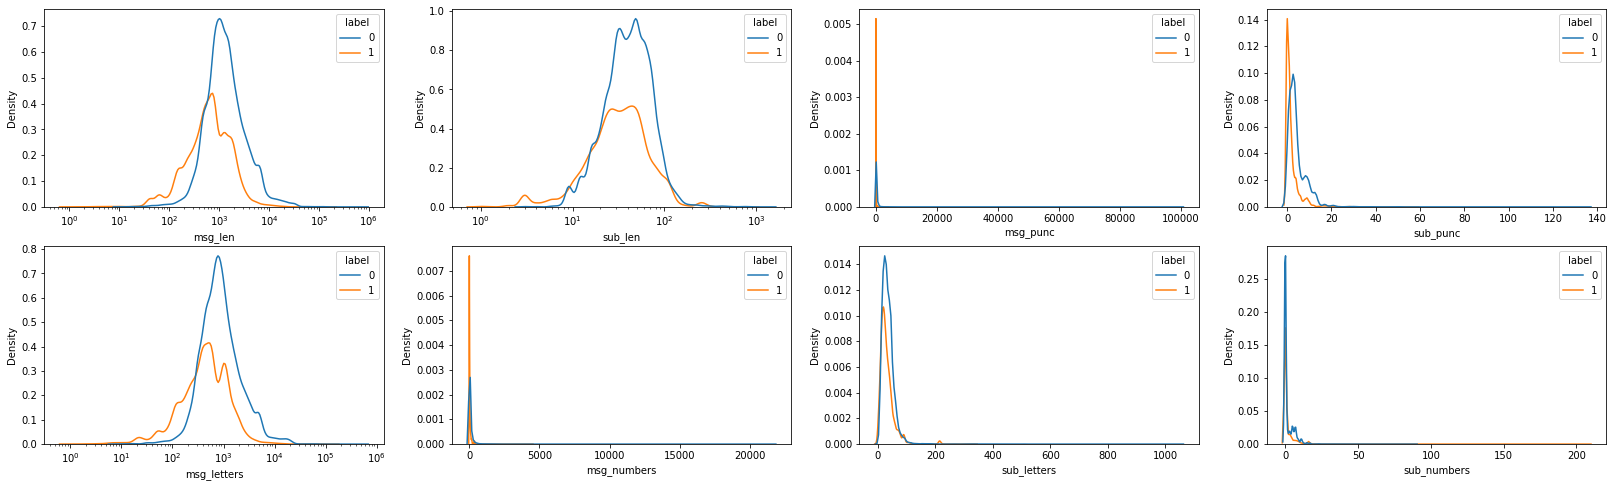

In [99]:
#New distrubution after dropping rows with no ascii characters
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (28,8))
sns.kdeplot(data=df_exp, x="msg_len", hue="label", ax=axes[0][0], log_scale=True)
sns.kdeplot(data=df_exp, x="sub_len", hue="label", ax=axes[0][1], log_scale=True)
sns.kdeplot(data=df_exp, x="msg_punc", hue="label", ax=axes[0][2])
sns.kdeplot(data=df_exp, x="sub_punc", hue="label", ax=axes[0][3])
sns.kdeplot(data=df_exp, x="msg_letters", hue="label", ax=axes[1][0], log_scale=True)
sns.kdeplot(data=df_exp, x="msg_numbers", hue="label", ax=axes[1][1])
sns.kdeplot(data=df_exp, x="sub_letters", hue="label", ax=axes[1][2])
sns.kdeplot(data=df_exp, x="sub_numbers", hue="label", ax=axes[1][3])

**Findings:**

* There is significant overlap in the distributions between the numerical features of the messages and subjects, and would likely make differentiating them without using their textual contexts very difficult.
* There is a very wide distribution in message and subject length, punctuation counts, and the number of ASCII letters and numbers across both classes of emails. The vast majority of message lengths are concentrated are around 1000 in character length; whilst the majority of email subject line are between 100 to 1000 in characters in length.
* Punctuation and numeric characters have a very wide range, but are concentrated on the lower end for both classes (for both message and subject).



---




# Preparation for Model Training
We will use NLP preprocessing steps to prepare the textual data in a way that will allow it to be used to train some basic machine learning models. We will create several classification models to train and test the data we have used. 

Note that a small fraction of the entire dataset will be used in lieu of the entire dataset itself. This is because huge dataset sizes can be inefficient to train in a time-effective manner. 